In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [2]:
dir_path = '../../../data/pseudobulks/'

In [3]:
os.listdir(dir_path)

['annotation_chimp.csv',
 'annotation_human.csv',
 'annotation_macaque.csv',
 'annotation_spatial_libd_human.csv',
 'expression_chimp.csv',
 'expression_human.csv',
 'expression_macaque.csv',
 'expression_mean_chimp.csv',
 'expression_mean_human.csv',
 'expression_mean_macaque.csv',
 'expression_mean_spatial_libd_human.csv',
 'expression_spatial_libd_human.csv',
 'expression_sum_chimp.csv',
 'expression_sum_human.csv',
 'expression_sum_macaque.csv',
 'expression_sum_spatial_libd_human.csv',
 'gene_sample_mean_chimp.csv',
 'gene_sample_mean_human.csv',
 'gene_sample_mean_macaque.csv',
 'gene_sample_mean_spatial_libd_human.csv',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_age_sample_norm_zscore.h5ad',
 'pb_mamm.h5ad',
 'pb_mamm_filtered.h5ad',
 'pb_mamm_laminar_filtered.h5ad',
 'pb_mamm_laminar_sample_zscore_filtered.h5ad',
 'pb_mamm_sample_norm.h5ad',
 'pb_mamm_sample_norm_filtered.h5ad',
 'pb_mamm_sample_norm_zscore.h5ad',
 'pb_mamm_sample_zscore_filtered.h5ad']

# ANOVA

Load pseudobulk data

In [4]:
file_name = 'pb_mamm.h5ad'
adata_pb = sc.read_h5ad(dir_path + file_name)
adata_pb

AnnData object with n_obs × n_vars = 94 × 15585
    obs: 'layer', 'sample_id', 'condition'

Remove technical repeats

In [5]:
adata_pb = adata_pb[adata_pb.obs.sample_id != 'chimp_13302'].copy()
adata_pb

AnnData object with n_obs × n_vars = 89 × 15585
    obs: 'layer', 'sample_id', 'condition'

Calculate library size

In [6]:
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

## Gene filltering

Fillter low expressed genes

In [7]:
adata_pb = adata_pb[:, adata_pb.X.mean(axis=0) > 0.05]
adata_pb

View of AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'

In [8]:
df = pd.DataFrame(adata_pb.X, index=adata_pb.obs_names, columns=adata_pb.var_names)
df[df < 0].notna().sum().sum()

0

In [9]:
adata_pb.write_h5ad('../../../data/pseudobulks/pb_mamm_filtered.h5ad')

## Sample normalization

In [10]:
def z_score(adata):
    pb_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
    pb_df['sample_id'] = adata.obs['sample_id']
    pb_df.head()
    # calculate statistics
    sample_mean = pb_df.groupby('sample_id').mean()
    sample_std = pb_df.groupby('sample_id').std()
    # calculate z-score
    columns = pb_df.columns.tolist()[:-1]
    for sample in tqdm(sample_mean.index.tolist()):
        pb_df.loc[pb_df.sample_id == sample, columns] = ((pb_df.loc[pb_df.sample_id == sample, columns] - sample_mean.loc[sample])
                                                         / sample_std.loc[sample]).fillna(0)
    # write adata
    adata.X = pb_df[columns].values
    return adata

Library normalization

In [11]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


D:\Projects\diploma\venv_stats2\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Sample normalization

In [12]:
adata_norm = z_score(adata_pb)

  0%|          | 0/13 [00:00<?, ?it/s]

In [13]:
df = pd.DataFrame(adata_norm.X, index=adata_norm.obs_names, columns=adata_norm.var_names)
df['condition'] = adata_norm.obs.condition
df['layer'] = adata_norm.obs.layer
grouped_mean = df.groupby(['layer', 'condition'][::-1]).mean()
grouped_mean_sum = (grouped_mean[grouped_mean == 0] + 1).sum()
zero_genes = grouped_mean_sum[grouped_mean_sum > 0].index

In [14]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


In [15]:
# save results
adata_norm.write_h5ad('../../../data/pseudobulks/pb_mamm_sample_zscore_filtered.h5ad')

D:\Projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
D:\Projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


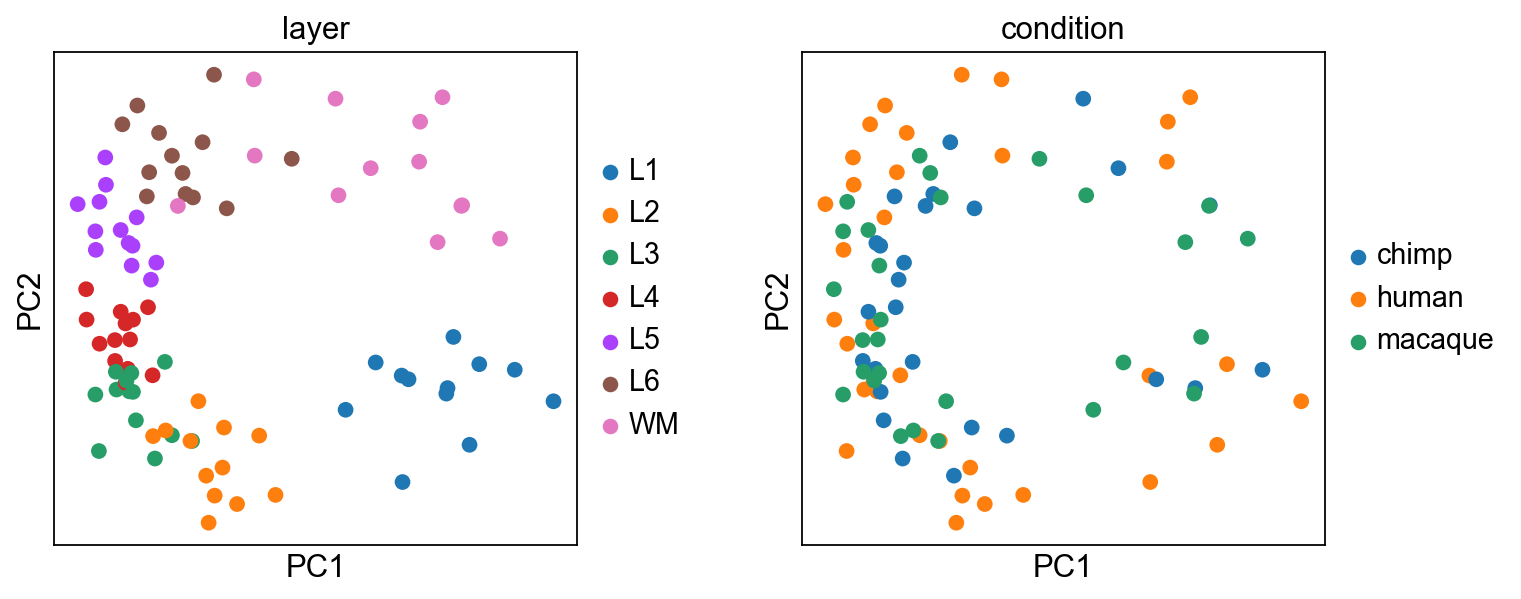

In [16]:
sc.pl.pca(adata_norm, color=['layer', 'condition'], size=200, ncols=3, wspace=0.3)

## ANOVA

In [17]:
file_name = 'pb_mamm_sample_zscore_filtered.h5ad'
adata = sc.read_h5ad(dir_path + file_name)
adata

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [18]:
# Make df for ANOVA
df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
df['condition'] = adata.obs.condition
df['layer'] = adata.obs.layer
df.head()

,NOC2L,HES4,AGRN,SDF4,B3GALT6,UBE2J2,SCNN1D,ACAP3,PUSL1,INTS11,...,SPATC1L,LSS,MCM3AP,YBEY,PCNT,DIP2A,S100B,PRMT2,condition,layer
WM.human_759,-0.650878,0.001029,-0.587605,-0.980993,0.472367,1.702099,-0.763371,2.107840,-0.168666,1.413201,...,1.371567,0.091970,0.263215,-1.660742,1.229293,2.069564,-0.043002,1.253314,human,WM
L5.human_759,0.915017,-1.205565,1.094584,-0.735551,1.957271,0.575298,-1.325118,-0.153488,1.188971,-1.648704,...,0.680849,-0.169549,0.190831,1.336182,0.303885,-0.040874,-0.537251,-0.525737,human,L5
L2.human_759,0.078276,1.329032,-1.277674,1.001606,-0.366053,-0.971476,1.537086,-0.364400,-0.362555,0.192616,...,0.223001,-1.230772,-1.508703,0.411800,-0.635369,-0.781407,-0.326476,0.482834,human,L2
L3.human_759,0.314214,0.062098,0.755363,-0.503540,-0.740480,-0.135018,-0.612045,-0.777390,0.168894,0.687944,...,-1.226639,-0.094421,1.691777,-0.449152,-0.432952,-0.828458,-0.521913,-0.859364,human,L3
L1.human_759,-1.874858,1.294498,-0.816885,1.145918,-0.526890,-1.202880,-0.098583,-0.504741,-1.933483,0.422461,...,-1.033139,1.874758,-0.846384,0.646753,1.406117,0.104341,2.236617,0.875557,human,L1


Replace gene names to `gene{i}` as `statsmodels` may fail

In [19]:
df_var_num = df.copy()
df_var_num.columns = [f'gene{i}' for i in range(1, df_var_num.shape[1] - 1)] + ['condition', 'layer']

In [20]:
# ANOVA for each gene
results = []

for gene in tqdm(df_var_num.columns.tolist()[:-2]):
    formula = f'{gene} ~ condition + layer + condition:layer'
    model = ols(formula, data=df_var_num).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    results.append(aov_table.loc['condition:layer'].tolist())

# save results to df
columns = ['sum_sq', 'df', 'F', 'PR(>F)']
res = pd.DataFrame(results, columns=columns, index=adata.var_names)
res.head()

  0%|          | 0/9208 [00:00<?, ?it/s]

,sum_sq,df,F,PR(>F)
NOC2L,6.384890,12.0,0.813337,0.635908
HES4,15.058197,12.0,1.878258,0.052758
AGRN,15.583493,12.0,3.171660,0.001230
SDF4,14.214074,12.0,1.574430,0.120231
B3GALT6,12.113356,12.0,1.676662,0.091658


## Multiple comparison correction

In [21]:
# Multiple comparison correction
mult_test = multipletests(res['PR(>F)'], method='fdr_bh')
res['p_val_adj'] = mult_test[1]
res.to_csv(f'./results/anova_zscore_mamm.csv')

In [22]:
res.head()

,sum_sq,df,F,PR(>F),p_val_adj
NOC2L,6.384890,12.0,0.813337,0.635908,0.716158
HES4,15.058197,12.0,1.878258,0.052758,0.121203
AGRN,15.583493,12.0,3.171660,0.001230,0.007732
SDF4,14.214074,12.0,1.574430,0.120231,0.220228
B3GALT6,12.113356,12.0,1.676662,0.091658,0.181660


<Axes: >

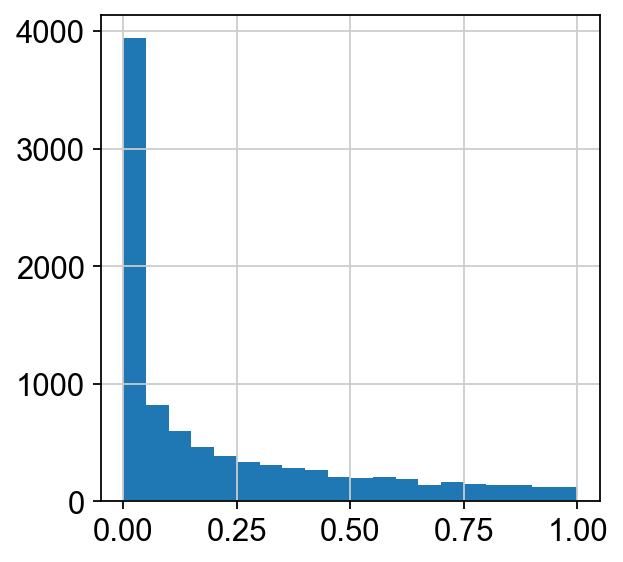

In [23]:
res['PR(>F)'].hist(bins=20)

## t-test

In [24]:
anova_res = pd.read_csv(f'./results/anova_zscore_mamm.csv', index_col=0)
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
NOC2L,6.384890,12.0,0.813337,0.635908,0.716158
HES4,15.058197,12.0,1.878258,0.052758,0.121203
AGRN,15.583493,12.0,3.171660,0.001230,0.007732
SDF4,14.214074,12.0,1.574430,0.120231,0.220228
B3GALT6,12.113356,12.0,1.676662,0.091658,0.181660


Leave only significant genes

In [25]:
sig_genes = anova_res[anova_res.p_val_adj < 0.05].index
sig_genes

Index(['AGRN', 'ANKRD65', 'TMEM240', 'NADK', 'GNB1', 'GABRD', 'TP73', 'CHD5',
       'GPR153', 'PLEKHG5',
       ...
       'BACE2', 'RSPH1', 'NDUFV3', 'RRP1', 'PFKL', 'COL18A1', 'COL6A2', 'LSS',
       'S100B', 'PRMT2'],
      dtype='object', length=2836)

In [26]:
from itertools import combinations
layers = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']
conditions = ['human', 'chimp', 'macaque']

In [27]:
from scipy.stats import ttest_ind
from itertools import combinations

columns = ['gene', 'layer', 'group1', 'group2', 'score', 'pvalue']
results = []


for layer in tqdm(layers):
    layer_results = []
    for group1, group2 in combinations(conditions, 2):
        for gene in sig_genes.tolist():
            values1 = df.loc[(df['layer'] == layer) & (df['condition'] == group1), gene].values
            values2 = df.loc[(df['layer'] == layer) & (df['condition'] == group2), gene].values
            ttest_res = ttest_ind(values1, values2)
            layer_results.append([gene, layer, group1, group2, ttest_res.statistic, ttest_res.pvalue])
    # Multiple comparison correction
    layer_results = pd.DataFrame(layer_results, columns=columns)
    layer_results.dropna(subset='pvalue', inplace=True)
    mult_test = multipletests(layer_results['pvalue'], method='fdr_bh')
    layer_results['p_val_adj'] = mult_test[1]
    results.append(layer_results)

  0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
ttest_results = pd.concat(results)
ttest_results

,gene,layer,group1,group2,score,pvalue,p_val_adj
0,AGRN,L1,human,chimp,0.334627,0.749294,0.871771
1,ANKRD65,L1,human,chimp,-0.558470,0.596733,0.772328
2,TMEM240,L1,human,chimp,2.100247,0.080450,0.274743
3,NADK,L1,human,chimp,-5.641027,0.001330,0.038326
4,GNB1,L1,human,chimp,0.164405,0.874811,0.941712
...,...,...,...,...,...,...,...
8503,COL18A1,WM,chimp,macaque,-1.142775,0.296673,0.493044
8504,COL6A2,WM,chimp,macaque,2.558945,0.042970,0.167021
8505,LSS,WM,chimp,macaque,-7.631691,0.000264,0.013946
8506,S100B,WM,chimp,macaque,-1.584508,0.164170,0.350163


In [29]:
ttest_results.to_csv('./results/ttest_zscore_mamm.csv')

## t-test human vs monkeys (as one group)

In [30]:
columns = ['gene', 'layer', 'group1', 'group2', 'score', 'pvalue']
results = []


for layer in tqdm(layers):
    layer_results = []
    for gene in sig_genes.tolist():
        values1 = df.loc[(df['layer'] == layer) & (df['condition'] == 'human'), gene].values
        values2 = df.loc[(df['layer'] == layer) & ((df['condition'] == 'chimp') | (df['condition'] == 'macaque')), gene].values
        ttest_res = ttest_ind(values1, values2)
        layer_results.append([gene, layer, 'human', 'monkeys', ttest_res.statistic, ttest_res.pvalue])
    # поправка на множественное сравнение
    layer_results = pd.DataFrame(layer_results, columns=columns)
    layer_results.dropna(subset='pvalue', inplace=True)
    mult_test = multipletests(layer_results['pvalue'], method='fdr_bh')
    layer_results['p_val_adj'] = mult_test[1]
    results.append(layer_results)

  0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
ttest_results = pd.concat(results)
ttest_results

,gene,layer,group1,group2,score,pvalue,p_val_adj
0,AGRN,L1,human,monkeys,-0.885076,0.396898,0.615757
1,ANKRD65,L1,human,monkeys,-1.125119,0.286818,0.510668
2,TMEM240,L1,human,monkeys,-0.417102,0.685416,0.821573
3,NADK,L1,human,monkeys,-2.353651,0.040388,0.197606
4,GNB1,L1,human,monkeys,-1.598049,0.141116,0.348914
...,...,...,...,...,...,...,...
2831,COL18A1,WM,human,monkeys,1.290104,0.223476,0.477601
2832,COL6A2,WM,human,monkeys,-1.045765,0.318106,0.571248
2833,LSS,WM,human,monkeys,-2.248164,0.046038,0.243588
2834,S100B,WM,human,monkeys,-0.543128,0.597875,0.772471


In [32]:
ttest_results.to_csv('./results/ttest_zscore_human_monkeys.csv')